# Recurrent Neural Networks
So far, the neural network architectures we have been using have been simple in the sense that they take in a single fixed size input and give a single fixed size output. What if we wanted to model something like language where we want to feed in different length words? Another issue is that each output is only dependent on the current input. It has no 'memory' of previous inputs. Recurrent neural networks address both these issues.

They do this by having an internal hidden state which can be thought of as a form of memory. At each time step, the new hidden state is calculated as a function of the previous hidden state and the current input. This hidden state can then be used to represent your output or can be put through another function to compute the outputs. When we say function we are referring to the same one used in standard neural network: linear combination followed by an activation function.

### $h_t = f(x_t, h_{t-1})$

As shown in the diagram below, which uses a further function to compute the output $o$ from the hidden state $s$, there are three matrices of parameters which we are trying to optimize: U, V and W. The diagram also demonstrates how these networks can be unfolded to show the variables at various time steps.

![](rnn.jpg)

Standard neural networks can only model one to one relationships while RNNs are extremely flexible in terms of input-output structures which is one of the reasons they are so powerful. You can imagine something like one to many being used to feed in a single image from which a caption is sequentially produced or a many to one being used to feed in a sentence sequentially and give a single output describing the sentiment of the sentence.

![](rnnlayouts.jpeg)

### Optimization
Surprisingly, with this increased complexity in structure, the optimization method does not become any more difficult. Despite having a different name, back-propagation through time, it is essentially the same thing. All you do is feed in your sequence sequentially to get the output, as usual. You then just calculate your error at each timestep and sum it as opposed to calculating the error at a single timestep like standard neural networks. Then you can use gradient descent to update your weights iteratively until you are satisfied with your network's performance.

RNNS are generally slower to optimize than standard neural networks as the output at each time step is dependent on the previous output so the operations cannot be parallelized.

For a long time it was considered difficult to train RNNs due to two problems called vanishing and exploding gradients. These problems also exist in standard neural network but are greatly emphasized in RNNs. However, modern techniques such as LSTM cells have greatly reduced this difficulty.

## Implementation
We are going to be implementing a one-to-one character level text prediction model. We will be sequentially feeding in a single character and asking our network to predict the next character based on the 'memory' stored in the hidden units of all the previous characters.

As always, we begin by importing the required libraries.

In [126]:
%matplotlib notebook
import torch
import numpy as np
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt

For this particular task, we will need to do quite a bit of pre-processing. We need to find the number of unique characters in our training text and give each one a unique number so we can one-hot encode them.<br>
We start by reading the file, converting all letters to lowercase to reduce the number of characters we need to model, then defining a function which takes in the text and gives up back a dictionary mapping each letter to a unique number.

In [196]:
def movie_corpus_tokeniser(corpus):
    ### IMPLEMENT
    #pass
    #tokens=[(x.split(" +++$+++ ")[-1].translate(str.maketrans('','',string.punctuation)).lower()+" <EOL>").split() for i,x in enumerate(corpus,1) if i<4]
    tokens=[(x.split(" +++$+++ ")[-1].lower()) for i,x in enumerate(corpus,1) if i<1004]
    #tokens=[x for x in corpus]
    #print("tokenst", tokens)
    return tokens



In [198]:
#open our text file and read all the data into the rawtxt variable
with open('movie_lines.txt', 'r',encoding="latin1") as file: #encoding="latin1"
    #print(movie_corpus_tokeniser(file))
    for t in file: 
        print(t)
        print(t.split(" +++$+++ ")[-1])
        print(list(set(t.split(" +++$+++ ")[-1].lower())))
        print(list(set(t.split(" +++$+++ ")[-1].lower().split()))) #2nd split separates words within sentences in not present only get whole sentence.
        break
    tokens1=movie_corpus_tokeniser(file)
with open('movie_lines.txt', 'r',encoding="latin1") as file: #encoding="latin1"
    rawtxt = file.read()
   # print("rawtxt", rawtxt)
    for tt in rawtxt: 
        print(tt)
        break

   # print('here', tokens1)
    #######print("moviefile", tokens1)
    #rawtxt = file.read()
    
    #print("read file: ", file.readline())


#print(tokens1)
vocab1 = [word for line in tokens1 for word in line]         # flatten out corpus into list of words
#print("vocabulary \n", vocab)
vocab = set(vocab1)                                                      # remove duplicates
print("vocabulary set: \n", vocab)
print("len vocabulary:", len(vocab))


L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!

They do not!

['e', '!', 'h', ' ', 'd', 'y', 'n', '\n', 't', 'o']
['they', 'do', 'not!']
L
vocabulary set: 
 {'m', '0', 'c', '5', 'i', 'z', 'y', 'k', '?', ':', 't', 'w', 'e', '!', 'h', '*', '\n', 'g', 'o', '.', 'l', 'b', '-', 'f', 'x', 'j', ' ', 'v', '9', 'q', '7', '"', 'p', 's', '2', 'u', 'd', '1', 'a', "'", 'n', ',', 'r'}
len vocabulary: 43


In [170]:
#open our text file and read all the data into the rawtxt variable
with open('lyrics.txt', 'r',encoding="utf-8") as file: #encoding="latin1"
    #for t in file: 
     #   print(t)
      #  break
    rawtxt = file.read()
    #print(file.readline())
    #print(rawtxt)

#turn all of the text into lowercase as it will reduce the number of characters that our algorithm needs to learn
rawtxt = rawtxt.lower()#.split()
#print(rawtxt)
#returns a dictionary that allows us to map from a unique number to a unique character in our text
def create_map(rawtxt):
    #print(rawtxt)
    #palab=[]
    #for word in rawtxt:
        #print(word)
       # if word not in palab:
            #print(word)
        #    palab.append(word)
    #print(palab)        
        
    letters = list(set(rawtxt)) #returns the list of unique characters in our raw text
    #print(letters)
    lettermap = dict(enumerate(letters)) #created the dictionary mapping
    print(lettermap)

    return lettermap

num_to_let = create_map(rawtxt) #store the dictionary mapping from numbers to characters in a variable
let_to_num = dict(zip(num_to_let.values(), num_to_let.keys())) #create the reverse mapping so we can map from a character to a unique number

nchars = len(num_to_let) #number of unique characters in our text file
print("num_to_let: ", num_to_let)
for x in num_to_let:
    print(type(x), type(num_to_let[x]))
    break



{0: 'm', 1: '0', 2: 'c', 3: '4', 4: '5', 5: 'i', 6: 'z', 7: 'y', 8: 'k', 9: ';', 10: '?', 11: ':', 12: '“', 13: 't', 14: '6', 15: 'w', 16: 'e', 17: '!', 18: 'h', 19: ']', 20: '‘', 21: '”', 22: '\n', 23: 'g', 24: 'o', 25: 'b', 26: 'l', 27: 'ś', 28: '.', 29: 'f', 30: '-', 31: '3', 32: 'x', 33: 'j', 34: ' ', 35: 'v', 36: '9', 37: '[', 38: ')', 39: 'q', 40: '7', 41: '"', 42: 'p', 43: 's', 44: '’', 45: '2', 46: 'u', 47: '(', 48: 'd', 49: '1', 50: '/', 51: 'a', 52: "'", 53: 'n', 54: ',', 55: 'r'}
num_to_let:  {0: 'm', 1: '0', 2: 'c', 3: '4', 4: '5', 5: 'i', 6: 'z', 7: 'y', 8: 'k', 9: ';', 10: '?', 11: ':', 12: '“', 13: 't', 14: '6', 15: 'w', 16: 'e', 17: '!', 18: 'h', 19: ']', 20: '‘', 21: '”', 22: '\n', 23: 'g', 24: 'o', 25: 'b', 26: 'l', 27: 'ś', 28: '.', 29: 'f', 30: '-', 31: '3', 32: 'x', 33: 'j', 34: ' ', 35: 'v', 36: '9', 37: '[', 38: ')', 39: 'q', 40: '7', 41: '"', 42: 'p', 43: 's', 44: '’', 45: '2', 46: 'u', 47: '(', 48: 'd', 49: '1', 50: '/', 51: 'a', 52: "'", 53: 'n', 54: ',', 55: 

In [199]:


#turn all of the text into lowercase as it will reduce the number of characters that our algorithm needs to learn
#rawtxt = rawtxt.lower()#.split()
#print(rawtxt)
#returns a dictionary that allows us to map from a unique number to a unique character in our text
def create_map(rawtxt):
    #print(rawtxt)
    #palab=[]
    #for word in rawtxt:
        #print(word)
       # if word not in palab:
            #print(word)
        #    palab.append(word)
    #print(palab)        
    letters = list(set(rawtxt)) #returns the list of unique characters in our raw text
    #print(letters)
    lettermap = dict(enumerate(letters)) #created the dictionary mapping
    print(lettermap)

    return lettermap
rawtxt=vocab1       


num_to_let = create_map(rawtxt) #store the dictionary mapping from numbers to characters in a variable
let_to_num = dict(zip(num_to_let.values(), num_to_let.keys())) #create the reverse mapping so we can map from a character to a unique number

nchars = len(num_to_let) #number of unique characters in our text file
print("num_to_let: ", num_to_let)
for x in num_to_let:
    print(type(x), type(num_to_let[x]))
    break


{0: 'm', 1: '0', 2: 'c', 3: '5', 4: 'i', 5: 'z', 6: 'y', 7: 'k', 8: '?', 9: ':', 10: 't', 11: 'w', 12: 'e', 13: '!', 14: 'h', 15: '*', 16: '\n', 17: 'g', 18: 'o', 19: '.', 20: 'l', 21: 'b', 22: '-', 23: 'f', 24: 'x', 25: 'j', 26: ' ', 27: 'v', 28: '9', 29: 'q', 30: '7', 31: '"', 32: 'p', 33: 's', 34: '2', 35: 'u', 36: 'd', 37: '1', 38: 'a', 39: "'", 40: 'n', 41: ',', 42: 'r'}
num_to_let:  {0: 'm', 1: '0', 2: 'c', 3: '5', 4: 'i', 5: 'z', 6: 'y', 7: 'k', 8: '?', 9: ':', 10: 't', 11: 'w', 12: 'e', 13: '!', 14: 'h', 15: '*', 16: '\n', 17: 'g', 18: 'o', 19: '.', 20: 'l', 21: 'b', 22: '-', 23: 'f', 24: 'x', 25: 'j', 26: ' ', 27: 'v', 28: '9', 29: 'q', 30: '7', 31: '"', 32: 'p', 33: 's', 34: '2', 35: 'u', 36: 'd', 37: '1', 38: 'a', 39: "'", 40: 'n', 41: ',', 42: 'r'}
<class 'int'> <class 'str'>


In [200]:
def maparray(txt, mapdict):
    
    txt = list(txt)

    #iterate through our text and change the value for each character to its mapped value
    for k, letter in enumerate(txt):
        txt[k] = mapdict[letter]

    txt = np.array(txt)
    return txt

#map our raw text into our input variables using the function defined earlier and passing in the mapping from letters to numbers
X = maparray(rawtxt, let_to_num)
Y = np.roll(X, -1, axis=0) #our label is the next character so roll shifts our array by one timestep
print(X, len(X))
print(Y)
print(np.shape(X))
#conver to torch tensors so we can use them in our torch model
X = torch.LongTensor(X)
Y = torch.LongTensor(Y)

#Example Aiz
q=np.array([1,2,3,4])
qq=np.roll(q,-1, axis=0)
print(q)
print(qq)


[10 14 12 ... 35 19 16] 45580
[14 12  6 ... 19 16 10]
(45580,)
[1 2 3 4]
[2 3 4 1]


Define our model which takes in variables defining its structure as parameters. The encoder converts each unique number into an embedding which is fed into the rnn model. The RNN calculates the hidden state which is converted into an output through a fully connected layer called the decoder.<br>
We also define the init_hidden function which outputs us a tensor of zeros of the required size for the hidden state.

In [201]:
class RNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super().__init__()
        #store input parameters in the object so we can use them later on
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        #required functions for model
        self.encoder = torch.nn.Embedding(input_size, input_size)
        self.rnn = torch.nn.GRU(input_size, hidden_size, n_layers, batch_first=True)
        self.decoder = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        x = self.encoder(x.view(1, -1)) #encode our input into a vector embedding
        output, hidden = self.rnn(x.view(1, 1, -1), hidden) #calculate the output from our rnn based on our input and previous hidden state
        output = self.decoder(output.view(1, -1)) #calculate our output based on output of rnn

        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size)) #initialize our hidden state to a matrix of 0s

Instantiate our model, define the appropriate hyper-parameters, cost function and optimizer. We will be training on ranom samples from the text of length chunk_size so it is what batch size is to normal neural networks.<br>
We also define the function which return a random chunk from the text which we can use to train out model.

In [202]:
#hyper-params
lr = 0.001
no_epochs = 20
chunk_size = 100 #the length of the sequences which we will optimize over

myrnn = RNN(nchars, 512, nchars, 1) #instantiate our model from the class defined earlier
criterion = torch.nn.CrossEntropyLoss() #define our cost function
optimizer = torch.optim.Adam(myrnn.parameters(), lr=lr) #choose optimizer
input = torch.randn(1, 5, requires_grad=True)
target = torch.empty(1, dtype=torch.long).random_(5)
p=0
p=+1
print(p)
print(input, input.size())
print(target,target.size())
print(criterion(input,target))
#return a random batch for training
def random_chunk(chunk_size):
    k = np.random.randint(0, len(X)-chunk_size)
    return X[k:k+chunk_size], Y[k:k+chunk_size]

1
tensor([[-1.0961, -1.1001, -0.2825, -1.2474, -0.7129]], requires_grad=True) torch.Size([1, 5])
tensor([4]) torch.Size([1])
tensor(1.5006, grad_fn=<NllLossBackward>)


Define the axes for plotting our cost per epoch. Define the training loop, sequentially feeding in a random chunk of text, summing the cost for each character in the sequence (backpropagation through time) and calculating the gradients to update our weights.

<IPython.core.display.Javascript object>


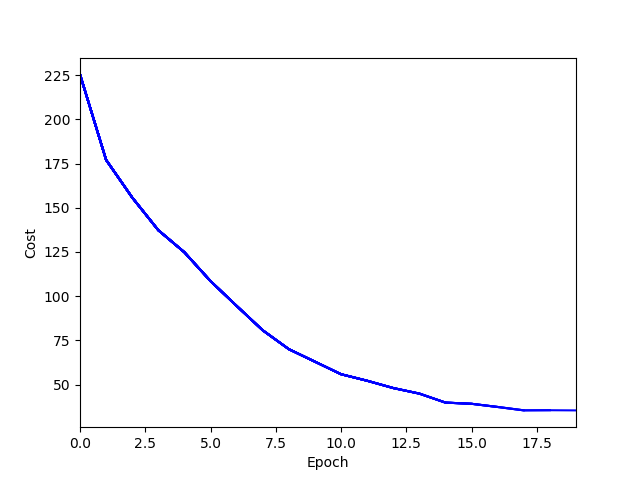

lenX 45580 
 chunk_size 100 len//chunk 455
totcost tensor(102572.2578)
Epoch  1  Avg cost/chunk:  tensor(225.4335)
Generated text:  ::obstst:vbbtgg::::::vvs!!vb:::sssb:ddxtgg---dbbd::dtgbagtovvssdg!slsvy::s:::0bdbdd:dtggd!s:v2-sa:0!bdsdtss  ssststusdtuatlt2bbds.::sdtusslsstttt.ts ttsttt.ttstitssbsuuuts tttssggssttysttssttas es ttsytr  ssstss    e     sesehet stseeee     sss  s  sssts  t     s sr  sa   ss sss      ss ss ss   bbeeyih   t            s         at   s         te      ss      s                    s   tsa    ss   sa sue                                                                                                 ssa                                                                                                 h                                                                                                    ss                                                

lenX 45580 
 chunk_size 100 len//chunk 455
totcost tensor(80570.0234)
Epoch  2  Avg cost/chunk:  tensor(177.0770)
G

In [203]:
#for plotting costs
costs = []
plt.ion()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Epoch')
ax.set_ylabel('Cost')
ax.set_xlim(0, no_epochs-1)
plt.show()


#training loop
def train(no_epochs):
    for epoch in range(no_epochs):
        totcost = 0 #stores the cost per epoch
        generated = '' #stores the text generated by our model each epoch
        #given our chunk size, how many chunks do we need to optimize over to have gone thorough our whole dataset
        for _ in range(len(X)//chunk_size):
            h = myrnn.init_hidden() #initialize our hidden state to 0s
            cost = 0 #cost for this chunk
            x, y = random_chunk(chunk_size) #get a random sequence chunk to train
            x, y = Variable(x), Variable(y) #turn into variables to be used with our model
            #sequentially input each character in our sequence and calculate loss
            for i in range(chunk_size):
                out, h = myrnn.forward(x[i], h) #calculate outputs based on input and previous hidden state

                #based on our output, what character does our network predict is next?
                _, outl = out.data.max(1) 
                
                #print(torch.LongTensor(outl[0].item()))
                #print("outl", outl)
                #print(type(outl[0]))
                #print("num_to_let: ", num_to_let[int(outl[0].item())])
                letter = num_to_let[int(outl[0].item())]
                generated+=letter #add the predicted letter to our generated sequence
                #print("out:",out,"shape", out.size())
                #print("y[i]: ",torch.LongTensor([y[i].item()]), "shape", torch.LongTensor([y[i].item()]).size())
                #print("criterion: ", criterion(out, torch.LongTensor([y[i].item()])))
                cost += criterion(out, torch.LongTensor([y[i].item()])) #add the cost for this input to the cost for this current chunk
                #print("cost: ", cost)
                                     
            #based on the sum of the cost for this sequence (backpropagation through time) calculate the gradients and update our weights
            optimizer.zero_grad() 
            cost.backward()
            optimizer.step()
            #print("cost ",cost.data)
            totcost += cost.data #add the cost of this sequence to the cost of this epoch
            
        print("lenX",len(X),"\n" ,"chunk_size", chunk_size, "len//chunk",  len(X)//chunk_size)
        print("totcost", totcost)
        totcost /= len(X)//chunk_size #divide by the number of chunks per epoch to get average cost per epoch

        #append the cost to the array and plot
        costs.append(totcost)
        ax.plot(costs, 'b')
        fig.canvas.draw()

        print('Epoch ', epoch+1, ' Avg cost/chunk: ', totcost)
        print('Generated text: ', generated[0:750], '\n')
        
train(no_epochs)

The generated text above picks the most probable next character each time. This is not the best way to do it as our model will be deterministic so it will produce the same text over and over again. To get it producing different text, we should instead sample from the probability distribution of possible next letters output by the network. That is what we will do with the next function.

In [217]:
def generate(prime_str='a', str_len=150, temperature=0.75):
    generated = prime_str
    
    #initialize hidden state
    h = myrnn.init_hidden()
    
    prime_str = maparray(prime_str, let_to_num)
    x = Variable(torch.LongTensor(prime_str))
    
    #primes our hidden state with the input string
    for i in range(len(x)):
        out, h = myrnn.forward(x[i], h)
    
    x = x[-1]
    
    for i in range(str_len):
        out, h = myrnn.forward(x, h)
        
        out_dist = out.data.view(-1).div(temperature).exp()
        sample = torch.multinomial(out_dist, 1)[0]
        pred_char = num_to_let[sample.item()]
        
        generated += pred_char
        
        x = Variable(torch.LongTensor([sample]))
    
    return generated
        
    

gen = generate('superman ', 1500, 0.75)
#gen = generate('b', 1500, 0.75)


print(gen)

superman do you wanna watch?  we're was lawasn.
okay, what --?
have a great time, honey!
dr. ruth?
what do you wanna watch?  we've got crap, crap, crap or crap
kissing?  is that that you could use it.
what?
i just wanted --
you set me up to give you the tour.
so they tell me...
you think i need anything for?
oh no!  no!  shit!
here.  i have your freshman yearbool?
i want to anymore than shit!
how?
then you must tell me you're too busy listening to sit doctor
that a was, like, a toop bial.
but was told me that put it out.  can you put the minutes?
no.
how do you think that would ask permission.
my father wouldn't approve of that that
start a band?
this.
daddy, but there is not son... rister nothing in my head and -
you told me that part a really great girl.
i don't get ussurely, i don't think it's abuse, i think it's torry of ....
but you hate joey
he was, like, a took back!
the "ight up the prom with me.  i'm she'd see any of the other was blind.
tell me absolution.
we lonk to reveal h